## Installation
```bash
pip install git+https://github.com/pgmpy/pgmpy.git@dev
```

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# get data
peng = sns.load_dataset('penguins', cache=True, data_home=None)
print(peng.shape)

# clean data to make continous variables categorical
cont_cols = list( peng.select_dtypes('float64').columns )

# number of levels
levels = 2

for col in cont_cols:
    peng[col] = pd.cut(  peng[col], levels )
    
    
# all to strings
peng = peng.dropna().astype(str)
    
# rename cols
peng = peng.rename( columns= dict( bill_length_mm = 'b_length'
                           , bill_depth_mm ='bill_depth', flipper_length_mm ='f_length',  body_mass_g= 'bm'), inplace=False)

# joint probs for only two variables
def joint_probs(DF, index, cols ):
    all_cols = index + cols
    N = DF.shape[0]
    
    joint_counts = pd.pivot_table( DF[all_cols] , index = index , columns= cols , aggfunc= 'size' ).replace(np.nan,0)
    
    joint_prob = np.round( joint_counts / N, 3)
    
    return joint_prob

def cond_prob_dist(joint_probs):
    # P(A | B) = P( A and B ) / P(B)
    ## https://en.wikipedia.org/wiki/Conditional_probability
    
    """
    calculates the conditions prob. distribution where:
    joint_probs: is a joint prob distribution as pandas dataframe
    A = {index   of joint_probs} = {a1, a2, .. an }
    B = {columns of joint_probs} = {b1, b2, .. bn }
    
    
    returns:
    CPD = the conditional probability dist P(A|B) as a pandas dataframe
    """
    
    CPD = joint_probs.copy()

    # column sum
    col_totals = joint_probs.sum(axis=0)
    
    for col in col_totals.index:
        CPD[col] =   CPD[col] / col_totals.loc[col]
        
    # rename columns
    CPD.columns = [ f'b{i+1} = {x}' for i,x in enumerate(CPD.columns) ]
    CPD.index   = [ f'a{i+1} = {x}' for i,x in enumerate(CPD.index) ]
        
    return CPD.round(3)

def conditional_analysis(DF, As = ['bm'], B = 'sex'):
    for a in As:
        print(f'A = {a} , B = {B}','', sep='\n')
        # P(A)
        print('1) Marginal Probs ','' , peng[a].value_counts(normalize=1).round(2).to_string(),'', sep='\n')
    
        # P(A|B)
        cpd = cond_prob_dist( joint_probs(peng,[a],[B]))
        print('2) Conditional Prob. Dist \n', f'P(A|B) for A = {a}', '', cpd,'',sep='\n')

    
        # E[ A | B]
        # expectation value
        r, _ = cpd.shape
        outcomes = np.arange(1,r+1)
        print(f'3) Conditional Expectations: E[ {a}|{B} ] \n',sep='\n')
        for q in cpd.columns:
            print(f'E[ {a} | {q} = ', np.round(np.sum(cpd[q]*outcomes),2) )

        print('---'*20, sep='\n')



(344, 7)


In [2]:
peng.head(2)

,species,island,b_length,bill_depth,f_length,bm,sex
0,Adelie,Torgersen,"(32.072, 45.85]","(17.3, 21.5]","(171.941, 201.5]","(2696.4, 4500.0]",Male
1,Adelie,Torgersen,"(32.072, 45.85]","(17.3, 21.5]","(171.941, 201.5]","(2696.4, 4500.0]",Female


## Allocate graphical model

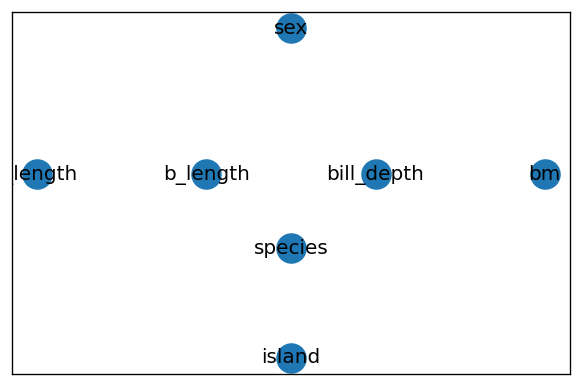

In [3]:
from pgmpy.models import BayesianNetwork
import networkx as nx

G  = BayesianNetwork() # graph object
G.add_nodes_from(list(peng.columns))
p = nx.circular_layout(G)

p['sex']    = [.15,2]
p['species']= [.15,-1]
p['island']= [.15,-2.5]


p['f_length'] = [0,0]
p['b_length'] = [.1,0]
p['bill_depth'] = [.2,0 ]
p['bm'] = [.3,0]


def plot_dag(DAG,pos):
    plt.figure(dpi=120)
    nx.draw_networkx_labels(DAG,pos=pos)
    nx.draw_networkx_nodes(DAG,pos=pos)
    nx.draw_networkx_edges(DAG,pos=pos)
    
plot_dag(G,p)

### A = Species B = Sex

In [4]:
conditional_analysis(peng, As=['species'], B='sex')

A = species , B = sex

1) Marginal Probs 

Adelie       0.44
Gentoo       0.36
Chinstrap    0.20

2) Conditional Prob. Dist 

P(A|B) for A = species

                b1 = Female  b2 = Male
a1 = Adelie           0.442      0.435
a2 = Chinstrap        0.206      0.202
a3 = Gentoo           0.352      0.363

3) Conditional Expectations: E[ species|sex ] 

E[ species | b1 = Female =  1.91
E[ species | b2 = Male =  1.93
------------------------------------------------------------


## A = ['island', 'b_length', 'bill_depth', 'f_length', 'bm']
## B = sex

In [5]:
conditional_analysis(peng, As= ['island'], B='sex')

A = island , B = sex

1) Marginal Probs 

Biscoe       0.49
Dream        0.37
Torgersen    0.14

2) Conditional Prob. Dist 

P(A|B) for A = island

                b1 = Female  b2 = Male
a1 = Biscoe           0.485      0.494
a2 = Dream            0.370      0.369
a3 = Torgersen        0.145      0.137

3) Conditional Expectations: E[ island|sex ] 

E[ island | b1 = Female =  1.66
E[ island | b2 = Male =  1.64
------------------------------------------------------------


In [6]:
conditional_analysis(peng, As= ['b_length','bill_depth','f_length','bm'], B='sex')

A = b_length , B = sex

1) Marginal Probs 

(32.072, 45.85]    0.59
(45.85, 59.6]      0.41

2) Conditional Prob. Dist 

P(A|B) for A = b_length

                      b1 = Female  b2 = Male
a1 = (32.072, 45.85]        0.721      0.458
a2 = (45.85, 59.6]          0.279      0.542

3) Conditional Expectations: E[ b_length|sex ] 

E[ b_length | b1 = Female =  1.28
E[ b_length | b2 = Male =  1.54
------------------------------------------------------------
A = bill_depth , B = sex

1) Marginal Probs 

(13.092, 17.3]    0.51
(17.3, 21.5]      0.49

2) Conditional Prob. Dist 

P(A|B) for A = bill_depth

                     b1 = Female  b2 = Male
a1 = (13.092, 17.3]        0.636      0.381
a2 = (17.3, 21.5]          0.364      0.619

3) Conditional Expectations: E[ bill_depth|sex ] 

E[ bill_depth | b1 = Female =  1.36
E[ bill_depth | b2 = Male =  1.62
------------------------------------------------------------
A = f_length , B = sex

1) Marginal Probs 

(171.941, 201.5]    0.59
(201.5, 23

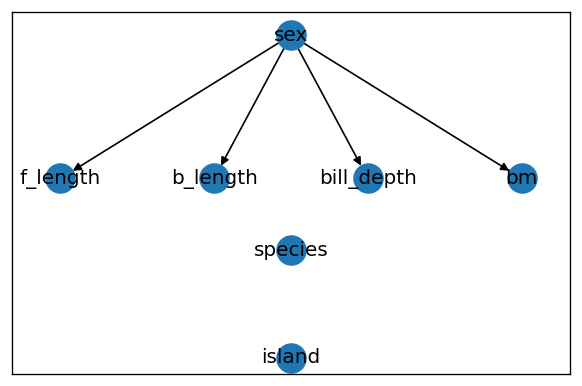

In [7]:
# add edges
G.add_edges_from(ebunch=[('sex',n) for n in ['b_length','bill_depth','f_length','bm'] ] )

plot_dag(G,p)

## A = species B = island

In [8]:
conditional_analysis(peng, As = ['species'], B = 'island')

A = species , B = island

1) Marginal Probs 

Adelie       0.44
Gentoo       0.36
Chinstrap    0.20

2) Conditional Prob. Dist 

P(A|B) for A = species

                b1 = Biscoe  b2 = Dream  b3 = Torgersen
a1 = Adelie            0.27       0.447             1.0
a2 = Chinstrap         0.00       0.553             0.0
a3 = Gentoo            0.73       0.000             0.0

3) Conditional Expectations: E[ species|island ] 

E[ species | b1 = Biscoe =  2.46
E[ species | b2 = Dream =  1.55
E[ species | b3 = Torgersen =  1.0
------------------------------------------------------------


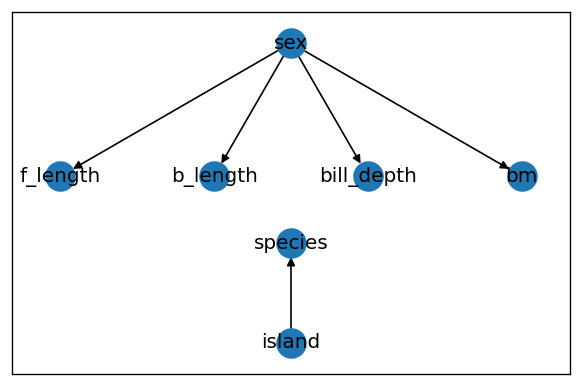

In [9]:
G.add_edge('island','species')
plot_dag(G,p)

In [10]:
conditional_analysis(peng, As = ['sex'], B = 'species')

A = sex , B = species

1) Marginal Probs 

Male      0.5
Female    0.5

2) Conditional Prob. Dist 

P(A|B) for A = sex

             b1 = Adelie  b2 = Chinstrap  b3 = Gentoo
a1 = Female          0.5             0.5        0.487
a2 = Male            0.5             0.5        0.513

3) Conditional Expectations: E[ sex|species ] 

E[ sex | b1 = Adelie =  1.5
E[ sex | b2 = Chinstrap =  1.5
E[ sex | b3 = Gentoo =  1.51
------------------------------------------------------------


In [11]:
conditional_analysis(peng, As = ['b_length', 'bill_depth', 'f_length', 'bm'], B = 'species')

A = b_length , B = species

1) Marginal Probs 

(32.072, 45.85]    0.59
(45.85, 59.6]      0.41

2) Conditional Prob. Dist 

P(A|B) for A = b_length

                      b1 = Adelie  b2 = Chinstrap  b3 = Gentoo
a1 = (32.072, 45.85]        0.993           0.191        0.319
a2 = (45.85, 59.6]          0.007           0.809        0.681

3) Conditional Expectations: E[ b_length|species ] 

E[ b_length | b1 = Adelie =  1.01
E[ b_length | b2 = Chinstrap =  1.81
E[ b_length | b3 = Gentoo =  1.68
------------------------------------------------------------
A = bill_depth , B = species

1) Marginal Probs 

(13.092, 17.3]    0.51
(17.3, 21.5]      0.49

2) Conditional Prob. Dist 

P(A|B) for A = bill_depth

                     b1 = Adelie  b2 = Chinstrap  b3 = Gentoo
a1 = (13.092, 17.3]        0.233           0.235          1.0
a2 = (17.3, 21.5]          0.767           0.765          0.0

3) Conditional Expectations: E[ bill_depth|species ] 

E[ bill_depth | b1 = Adelie =  1.77
E[ bill_dep

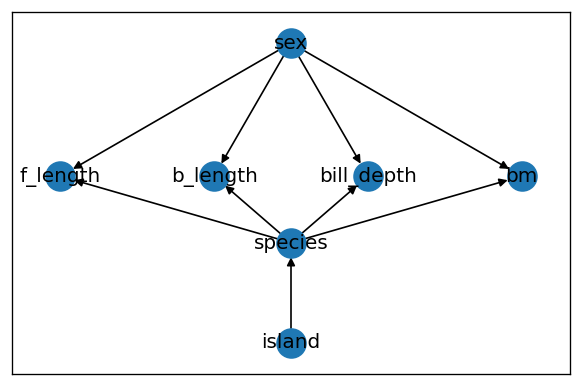

In [12]:
G.add_edges_from( ebunch  =  [('species',x) for x in ['b_length', 'bill_depth', 'f_length', 'bm'] ])
plot_dag(G,p)

## Estimate CPD and other properties

In [13]:
G.fit(peng)
print(G.get_cpds("island").to_factor())

+-------------------+---------------+
| island            |   phi(island) |
+===================+===============+
| island(Biscoe)    |        0.4895 |
+-------------------+---------------+
| island(Dream)     |        0.3694 |
+-------------------+---------------+
| island(Torgersen) |        0.1411 |
+-------------------+---------------+


In [14]:
print(G.get_cpds("species").to_factor())

+--------------------+-------------------+-----------------------+
| species            | island            |   phi(species,island) |
+====================+===================+=======================+
| species(Adelie)    | island(Biscoe)    |                0.2699 |
+--------------------+-------------------+-----------------------+
| species(Adelie)    | island(Dream)     |                0.4472 |
+--------------------+-------------------+-----------------------+
| species(Adelie)    | island(Torgersen) |                1.0000 |
+--------------------+-------------------+-----------------------+
| species(Chinstrap) | island(Biscoe)    |                0.0000 |
+--------------------+-------------------+-----------------------+
| species(Chinstrap) | island(Dream)     |                0.5528 |
+--------------------+-------------------+-----------------------+
| species(Chinstrap) | island(Torgersen) |                0.0000 |
+--------------------+-------------------+--------------------

In [15]:
print(G.get_cpds("bm").to_factor())

+----------------------+-------------+--------------------+-----------------------+
| bm                   | sex         | species            |   phi(bm,sex,species) |
+======================+=============+====================+=======================+
| bm((2696.4, 4500.0]) | sex(Female) | species(Adelie)    |                1.0000 |
+----------------------+-------------+--------------------+-----------------------+
| bm((2696.4, 4500.0]) | sex(Female) | species(Chinstrap) |                1.0000 |
+----------------------+-------------+--------------------+-----------------------+
| bm((2696.4, 4500.0]) | sex(Female) | species(Gentoo)    |                0.2759 |
+----------------------+-------------+--------------------+-----------------------+
| bm((2696.4, 4500.0]) | sex(Male)   | species(Adelie)    |                0.9041 |
+----------------------+-------------+--------------------+-----------------------+
| bm((2696.4, 4500.0]) | sex(Male)   | species(Chinstrap) |                0

## Variable Elimination and Queries

In [16]:
from pgmpy.utils import get_example_model

# Initializing the VariableElimination class
from pgmpy.inference import VariableElimination
peng_infer = VariableElimination(G)

In [17]:
print( peng_infer.query(variables=['species'], evidence= None, show_progress=False) )

+--------------------+----------------+
| species            |   phi(species) |
+====================+================+
| species(Adelie)    |         0.4384 |
+--------------------+----------------+
| species(Chinstrap) |         0.2042 |
+--------------------+----------------+
| species(Gentoo)    |         0.3574 |
+--------------------+----------------+


In [18]:
# Computing the probability of island given  sex = Female

for sex in ['Female','Male']:
    print(f'sex = {sex}')
    q = peng_infer.query(variables=['species'], evidence=dict( sex = sex), show_progress=False)
    print(q)
    print()

sex = Female
+--------------------+----------------+
| species            |   phi(species) |
+====================+================+
| species(Adelie)    |         0.4384 |
+--------------------+----------------+
| species(Chinstrap) |         0.2042 |
+--------------------+----------------+
| species(Gentoo)    |         0.3574 |
+--------------------+----------------+

sex = Male
+--------------------+----------------+
| species            |   phi(species) |
+====================+================+
| species(Adelie)    |         0.4384 |
+--------------------+----------------+
| species(Chinstrap) |         0.2042 |
+--------------------+----------------+
| species(Gentoo)    |         0.3574 |
+--------------------+----------------+



In [19]:
for sex in ['Female','Male']:
    print(f'sex = {sex}')
    q = peng_infer.query(variables=['species'], evidence=dict( sex = sex, bill_depth='(17.3, 21.5]'), show_progress=False)
    print(q)
    print()

sex = Female
+--------------------+----------------+
| species            |   phi(species) |
+====================+================+
| species(Adelie)    |         0.7000 |
+--------------------+----------------+
| species(Chinstrap) |         0.3000 |
+--------------------+----------------+
| species(Gentoo)    |         0.0000 |
+--------------------+----------------+

sex = Male
+--------------------+----------------+
| species            |   phi(species) |
+====================+================+
| species(Adelie)    |         0.6731 |
+--------------------+----------------+
| species(Chinstrap) |         0.3269 |
+--------------------+----------------+
| species(Gentoo)    |         0.0000 |
+--------------------+----------------+



In [20]:
# Computing the probability of island given  sex = male
for FL in peng['f_length'].unique():
    for bm in peng['bm'].unique():
        q = peng_infer.query(variables=['island'], evidence=dict( f_length = FL, bm=bm), show_progress=False, joint=True)
        print()
        print(f'f_length = {FL} | bm = {bm}')
        print(q)
        print('===='*10,sep='\n'*2)


f_length = (171.941, 201.5] | bm = (2696.4, 4500.0]
+-------------------+---------------+
| island            |   phi(island) |
+===================+===============+
| island(Biscoe)    |        0.2150 |
+-------------------+---------------+
| island(Dream)     |        0.5554 |
+-------------------+---------------+
| island(Torgersen) |        0.2296 |
+-------------------+---------------+

f_length = (171.941, 201.5] | bm = (4500.0, 6300.0]
+-------------------+---------------+
| island            |   phi(island) |
+===================+===============+
| island(Biscoe)    |        0.2515 |
+-------------------+---------------+
| island(Dream)     |        0.4799 |
+-------------------+---------------+
| island(Torgersen) |        0.2686 |
+-------------------+---------------+

f_length = (201.5, 231.0] | bm = (2696.4, 4500.0]
+-------------------+---------------+
| island            |   phi(island) |
+===================+===============+
| island(Biscoe)    |        0.5245 |
+------